In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
#jupyter内で画像を表示
%matplotlib inline 
#別ウィンドウで画像表示
# %matplotlib qt 
import csv
import json
from ipywidgets import interact, interactive, fixed, RadioButtons
import ipywidgets as widgets
from IPython.display import display
import pathlib
# sigo_path = pathlib.Path('../../ns3.30/data/sigo/shutoushu-nodenum_900_seed_43222.csv')
sigo_path = pathlib.Path('../data/propagation_test/test_lsgo-seed_55000nodenum_1000.csv')
lsgo_path = pathlib.Path('../data/lsgo/lsgo-seed_55000nodenum_1000.csv')

# csvファイルの取得
pandasを利用：https://note.nkmk.me/python-pandas-value-counts/

In [2]:
sigo_df = pd.read_csv(sigo_path)
lsgo_df = pd.read_csv(lsgo_path)
sigo_df.hopcount.head()

0    1
1    1
2    1
3    1
4    2
Name: hopcount, dtype: int64

# destination_idごとのパケット数

In [3]:
lsgo_df['destination_id'].value_counts().to_dict()

{2: 3,
 55: 32,
 132: 12,
 168: 186,
 186: 22,
 210: 5,
 213: 28,
 218: 89,
 252: 6,
 344: 35,
 352: 35,
 356: 28,
 418: 7,
 428: 26,
 439: 66,
 448: 93,
 452: 4,
 460: 114,
 471: 19}


destination_id を重複なしにリスト保存

In [4]:
sigo_df['destination_id'].value_counts().to_dict()

{2: 28,
 55: 38,
 106: 323,
 132: 23,
 186: 21,
 210: 61,
 213: 15,
 218: 47,
 252: 6,
 344: 2,
 352: 12,
 356: 4,
 418: 6,
 428: 30,
 439: 53,
 448: 80,
 452: 10,
 460: 77,
 471: 8}

In [5]:
dest_list = lsgo_df['destination_id'].value_counts().index.tolist()
dest_list.sort()
len(dest_list)

19

sigoとlsgoそれぞれ目的地に届いたidだけをlistに保存

In [6]:
sigo_reach_list = sigo_df[sigo_df['recv_id'] == sigo_df['destination_id']]['destination_id'].value_counts().index.tolist()
lsgo_reach_list = lsgo_df[lsgo_df['recv_id'] == lsgo_df['destination_id']]['destination_id'].value_counts().index.tolist()
sigo_reach_list.sort()
lsgo_reach_list.sort()

print('sigo:',sigo_reach_list)
print('lsgo:',lsgo_reach_list)

sigo: [2, 55, 132, 186, 210, 218, 428, 439, 448, 460]
lsgo: [55, 186, 213, 218, 344, 428, 439, 448, 460]


# 平均delayを返すメソッド

In [7]:
def packet_delay(path):
    delay_list = []
    #csvファイルの取得
    path_df = pd.read_csv(path)
    #目的地に届いたidだけをlistに保存
    reach_list = path_df[path_df['recv_id'] == path_df['destination_id']]['destination_id'].value_counts().index.tolist()
    #reach_listを回す
    for reach_id in reach_list:
        source_time = path_df[path_df['destination_id'] == reach_id]['time']
        recv_time = path_df[(path_df['destination_id'] == reach_id) & (path_df['destination_id'] == path_df['recv_id'])]['time']
        delay = int(recv_time.head(1).iloc[-1]) - int(source_time.head(1).iloc[-1])
        delay = delay / 100000
#         print('desID:', reach_id, 'delay:',delay)
        delay_list.append(delay)
    delay_mean = np.mean(delay_list)
    return delay_mean

In [8]:
packet_delay(sigo_path)

0.338821

In [9]:
packet_delay(lsgo_path)

0.3813688888888889

# 軌跡描画

In [10]:
def draw_source_area(log, img_area):
    cv2.rectangle(img_area, (log.source_x - 15, log.source_y - 15), (log.source_x + 15, log.source_y + 15), (255, 255, 0),thickness=8)
    cv2.rectangle(img_area, (log.destination_x - 15, log.destination_y - 15), (log.destination_x + 15, log.destination_y + 15), (255, 255, 0),thickness=8)
    #source nodeを視覚で囲む
    cv2.rectangle(img_area, (log.source_x - 15, log.source_y - 15), (log.source_x + 15, log.source_y + 15), (255, 255, 0),thickness=8)

    #方眼
    plt.figure(figsize=(20, 20))
    print('グラフサイズ')
    plt.grid(color='r', linestyle='dotted', linewidth=1.0)
    plt.xlim([-100, 2200])
    plt.xticks([2100,1800,1500,1200,900,600,300, 0]) 
    plt.ylim([-100, 2200])
    plt.yticks([0,300,600,900,1200,1500,1800,2100])  #メモリの間隔を指定 
    print('source_area 描画', log.source_x)

# パケットの軌跡を描画
def draw(log,count,img_area,protocol,text):
    if protocol == 'sigo':
        line_color = (0, 255, 0)
        thick = 9
        des_thick = 8
    else:
        line_color = (255, 0, 255)
        thick = 4
        des_thick = 4
    
    cv2.arrowedLine(img_area,(log.source_x, log.source_y), 
                            (log.recv_x, log.recv_y), line_color, thickness=thick, tipLength=0.15)
    cv2.circle(img=img_area, center=(log.source_x,
                           log.source_y), radius=10, color=(255,0,0), thickness=-1)
    cv2.circle(img=img_area, center=(log.recv_x,
                           log.recv_y), radius=10, color=(255,0,0), thickness=-1)
    #受け取ったのが宛先だったならば
    if log.recv_id == log.destination_id:
        cv2.drawMarker(img_area, (log.recv_x, log.recv_y), line_color, thickness=des_thick, markerType=cv2.MARKER_TILTED_CROSS, markerSize=25)
    if text == 'あり':    
        cv2.putText(img_area, str(log.source_id), (log.source_x + 10,log.source_y +10 ), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), thickness=2)
        cv2.putText(img_area, str(log.recv_id), (log.recv_x + 10,log.recv_y +10 ), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), thickness=2)

sigo: [2, 55, 132, 186, 210, 218, 428, 439, 448, 460] PDR: 0.5263157894736842
lsgo: [55, 186, 213, 218, 344, 428, 439, 448, 460] PDR: 0.47368421052631576
sigo delay: 0.338821
lsgo delay: 0.3813688888888889


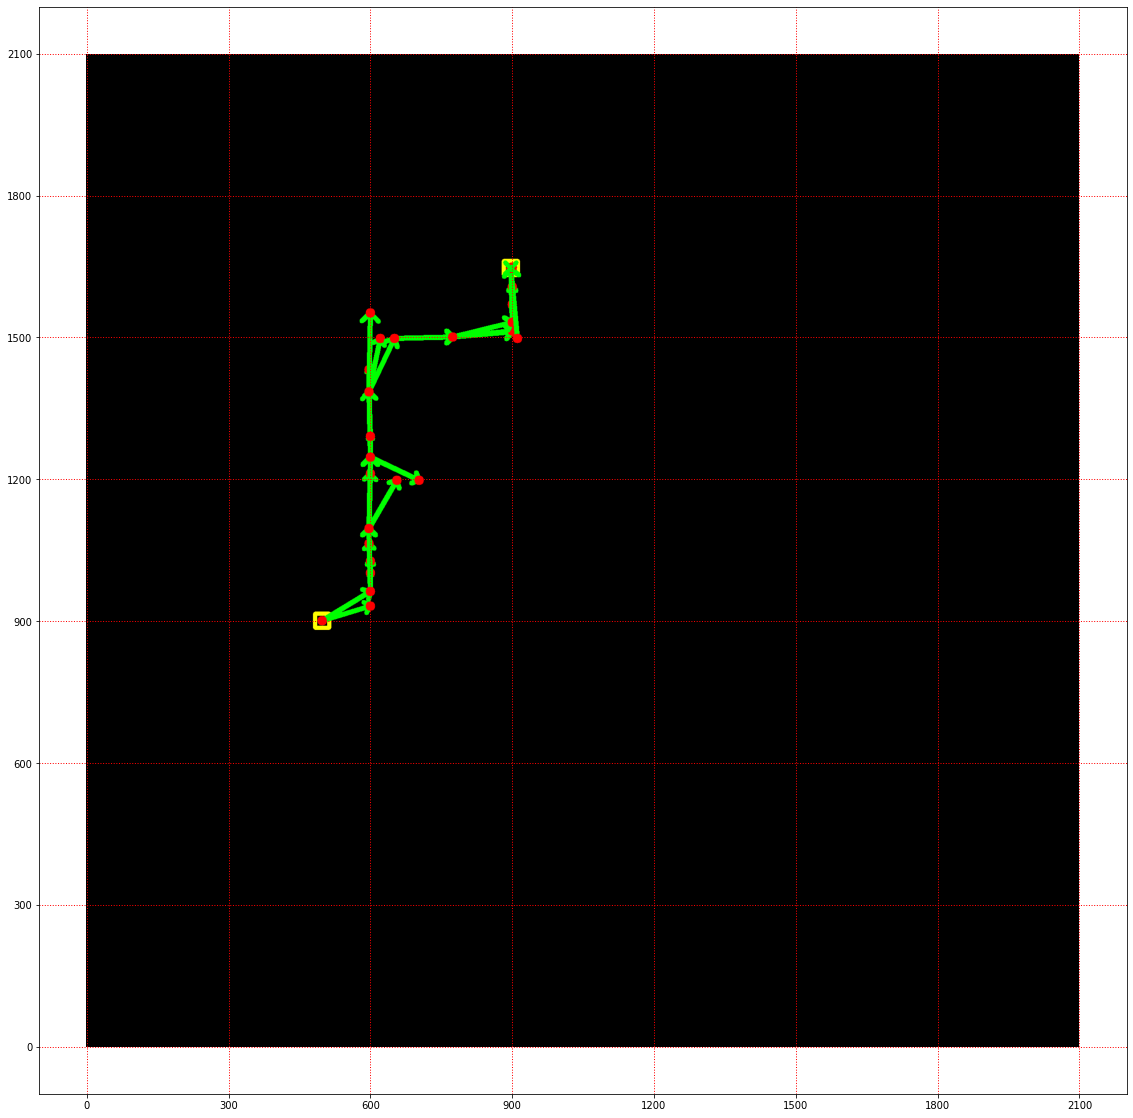

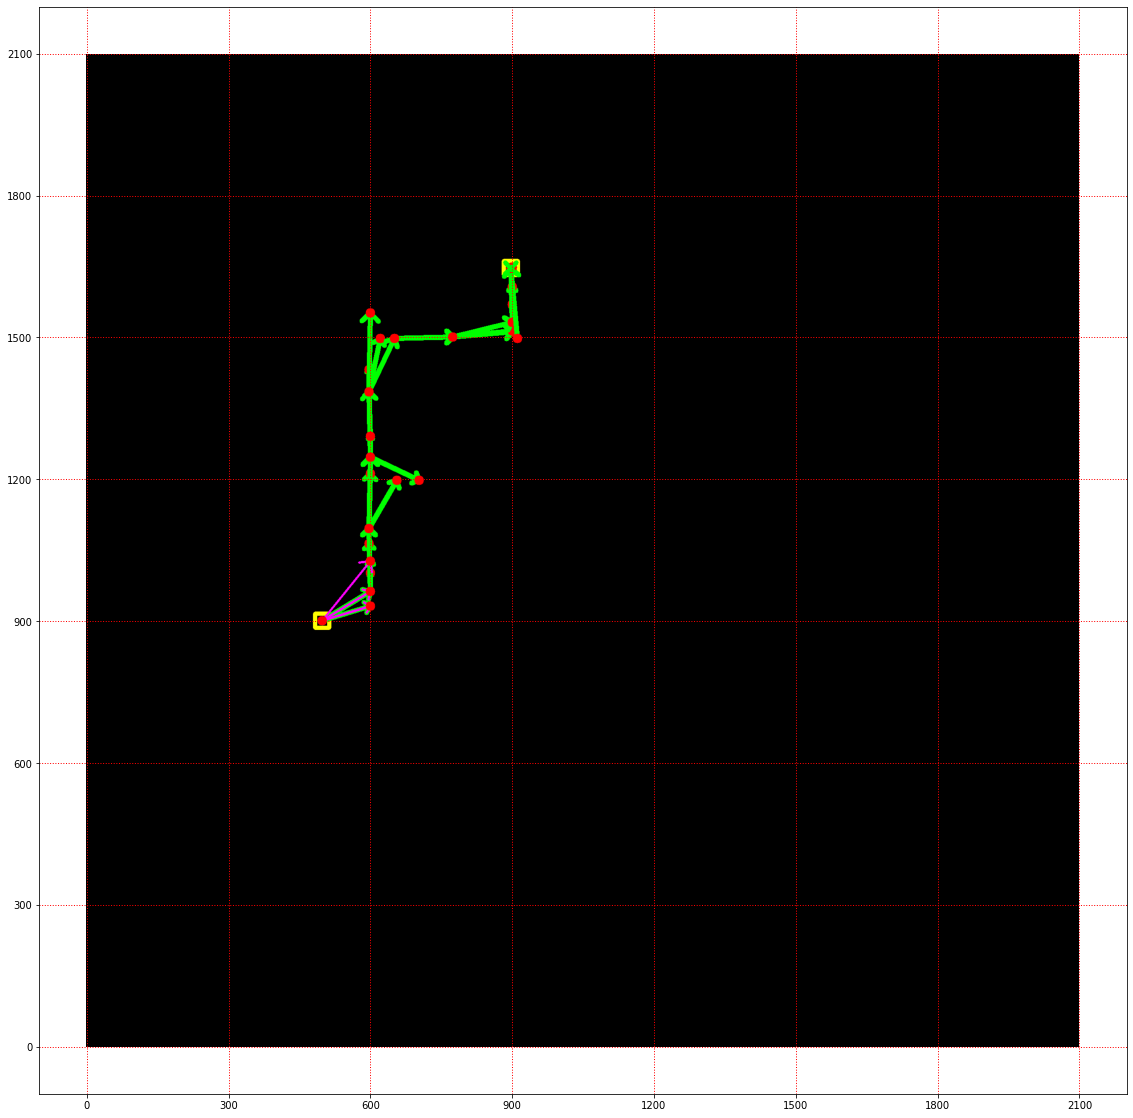

In [11]:
img_area = np.zeros(shape=(2100,2100, 3), dtype=np.int16)
protocol_list = ["sigo","lsgo", "both"]
text_list = ["なし", "あり"]
print('sigo:',sigo_reach_list,'PDR:',len(sigo_reach_list)/len(sigo_df['destination_id'].value_counts().index.tolist()))
print('lsgo:',lsgo_reach_list,'PDR:',len(lsgo_reach_list)/len(lsgo_df['destination_id'].value_counts().index.tolist()))
print('sigo delay:', packet_delay(sigo_path))
print('lsgo delay:', packet_delay(lsgo_path))

#packetの軌跡を描画 
@interact(minHop=(0,14,1), maxHop=(1,15, 1), desId=dest_list, protocol = protocol_list, text = text_list)
def packetDraw(protocol, desId, minHop=0, maxHop = 15, text = "なし"):
#     img_area = np.zeros(shape=(2100,2100, 3), dtype=np.int16)
    count = 1
    if protocol == 'sigo':
        for log in sigo_df[sigo_df['destination_id'] == desId].itertuples():
            if count == 1:
                draw_source_area(log, img_area)
                count = count +1
                
            if log.hopcount >= minHop and log.hopcount <= maxHop:
                draw(log,count,img_area,protocol,text)
#                 count = count +1
        print('img_areaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',img_area.shape)        
        plt.imshow(img_area)
    elif protocol == 'lsgo':
        for log in lsgo_df[lsgo_df['destination_id'] == desId].itertuples():
            if count == 1:
                draw_source_area(log, img_area)
                count = count +1
                
            if log.hopcount >= minHop and log.hopcount <= maxHop:
                draw(log,count,img_area,protocol,text)
#                 count = count +1
                
        plt.imshow(img_area)
    else:
        for log in sigo_df[sigo_df['destination_id'] == desId].itertuples():
            if count == 1:
                draw_source_area(log, img_area)
                count = count +1
                
            if log.hopcount >= minHop and log.hopcount <= maxHop:
                draw(log,count,img_area,'sigo',text)
#                 count = count +1
        for log in lsgo_df[lsgo_df['destination_id'] == desId].itertuples():
            if log.hopcount >= minHop and log.hopcount <= maxHop:
                draw(log,count,img_area,'lsgo',text)
#                 count = count +1
        plt.imshow(img_area)
        

In [61]:
lsgo_df[lsgo_df['destination_id'] == 210]

,source_x,source_y,recv_x,recv_y,time,recv_priority,hopcount,recv_id,source_id,destination_id,destination_x,destination_y,pri_1,pri_2,pri_3,pri_4,pri_5
662,1798,1593,1791,1498,29000200,2,1,58,453,210,598,1520,375,58,434,602,185
663,1798,1593,1758,1498,29000200,3,1,434,453,210,598,1520,375,58,434,602,185
664,1791,1498,1758,1498,29004400,2,2,434,58,210,598,1520,602,434,639,275,467
665,1791,1498,1713,1498,29004400,1,2,602,58,210,598,1520,602,434,639,275,467


In [62]:
sigo_df[sigo_df['destination_id'] == 210]

,source_x,source_y,recv_x,recv_y,time,recv_priority,hopcount,recv_id,source_id,destination_id,destination_x,destination_y,pri_1,pri_2,pri_3,pri_4,pri_5
638,1798,1593,1798,1525,29000200,5,1,283,453,210,598,1520,602,434,375,185,283
639,1798,1593,1758,1498,29000200,2,1,434,453,210,598,1520,602,434,375,185,283
640,1798,1593,1713,1498,29000200,1,1,602,453,210,598,1520,602,434,375,185,283
641,1713,1498,1609,1501,29000458,4,2,639,602,210,598,1520,87,275,467,639,783
642,1609,1501,1508,1501,29012659,5,3,87,639,210,598,1520,76,437,747,783,87
643,1609,1501,1501,1460,29012659,2,3,437,639,210,598,1520,76,437,747,783,87
644,1609,1501,1491,1498,29012659,1,3,76,639,210,598,1520,76,437,747,783,87
645,1609,1501,1498,1624,29012659,3,3,747,639,210,598,1520,76,437,747,783,87
646,1491,1498,1474,1498,29013073,5,4,416,76,210,598,1520,506,688,596,741,416
647,1491,1498,1420,1498,29013073,3,4,596,76,210,598,1520,506,688,596,741,416


In [60]:
# lsgo_df[(lsgo_df['destination_id'] == 278) & (lsgo_df['hopcount'] > 10)]